In [1]:
import os
import random
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [3]:
print(os.listdir("C:/Users/MUBASSIR/Downloads/Sport/dataset"))


['sample_submission.csv', 'test', 'test.csv', 'train', 'train.csv']


In [4]:
print(len(os.listdir("C:/Users/MUBASSIR/Downloads/Sport/dataset/train")))
print(len(os.listdir("C:/Users/MUBASSIR/Downloads/Sport/dataset/test")))

8227
2056


In [5]:
train = "C:/Users/MUBASSIR/Downloads/Sport/dataset/train"
test = "C:/Users/MUBASSIR/Downloads/Sport/dataset/test"
labels = pd.read_csv('C:/Users/MUBASSIR/Downloads/Sport/dataset/train.csv')
labels_test=pd.read_csv("C:/Users/MUBASSIR/Downloads/Sport/dataset/test.csv")

In [6]:
labels_test

,image_ID
0,f5e13966e7.jpg
1,6674191b4e.jpg
2,91b5f8b7a9.jpg
3,393119b6d6.jpg
4,1ce5f81578.jpg
...,...
2051,7be6c552a7.jpg
2052,4c9427f2a5.jpg
2053,0f429ae0d4.jpg
2054,a6557bedd9.jpg


In [7]:
print(labels['label'].value_counts())

Cricket      1556
Wrestling    1471
Tennis       1445
Badminton    1394
Soccer       1188
Swimming      595
Karate        578
Name: label, dtype: int64


In [8]:
batch_size = 64

In [9]:
datagen=ImageDataGenerator(rescale=1./255.)
train_generator = datagen.flow_from_dataframe(
                    dataframe = labels,
                    directory = train,
                    x_col = "image_ID",
                    y_col = ['label'],
                    subset = "training",
                    batch_size = batch_size,
                    seed = 42,
                    shuffle = True,
                    class_mode = "multi_output",
                    target_size = (64,64),
                    color_mode = 'grayscale')

# valid_generator = datagen.flow_from_dataframe(
#                     dataframe = train_df,
#                     directory = train_images_path,
#                     x_col = "Image",
#                     y_col = ['first_num','second_num'],
#                     subset = "validation",
#                     batch_size = batch_size,
#                     seed = 42,
#                     shuffle = True,
#                     class_mode = "multi_output",
#                     target_size = (64,64),
#                     color_mode = 'grayscale')

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(
                    dataframe = labels_test,
                    directory = test,
                    x_col = "image_ID",
                    y_col = [],
                    batch_size = batch_size,
                    seed = 42,
                    shuffle = True,
                    class_mode = "multi_output",
                    target_size = (64,64),
                    color_mode = 'grayscale')

Found 8227 validated image filenames.
Found 2056 validated image filenames.


In [10]:
import cv2

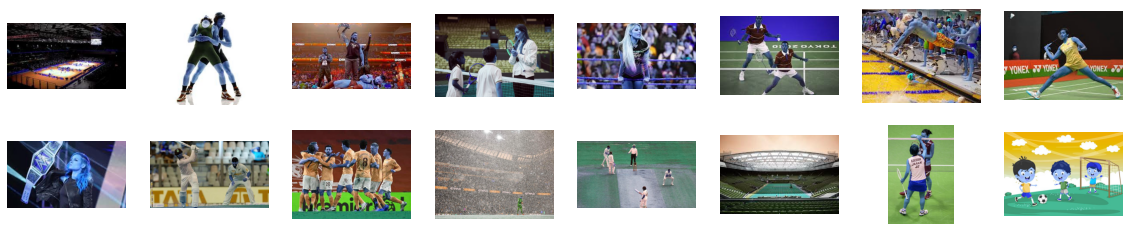

In [11]:
rand_images = random.sample(os.listdir(train), 16)

fig = plt.figure(figsize=(20,4))
for i, im in enumerate(rand_images):
    plt.subplot(2, 8, i+1)
    im = cv2.imread(os.path.join(train, im))
    plt.imshow(im)
    plt.axis('off')
plt.show()

In [12]:
validation_split = 0.8
idxs = np.random.permutation(range(len(labels))) < validation_split*len(labels)

train_labels = labels[idxs]
val_labels = labels[~idxs]
print(len(train_labels), len(val_labels))

6582 1645


In [13]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255, horizontal_flip=True, 
                                                             rotation_range=5,
                                                             shear_range=0.2,
                                                             height_shift_range=0.2,
                                                             width_shift_range=0.2,
                                                             vertical_flip=True,
                                                            fill_mode='nearest')
batch_size = 64

train_generator = train_datagen.flow_from_dataframe(train_labels,directory=train,x_col='image_ID',
                                                    y_col='label',class_mode='categorical',batch_size=batch_size,
                                                    target_size=(150,150))
val_generator = train_datagen.flow_from_dataframe(val_labels,directory=train,x_col='image_ID',
                                                    y_col='label',class_mode='categorical',batch_size=batch_size,
                                                    target_size=(150,150))

Found 6582 validated image filenames belonging to 7 classes.
Found 1645 validated image filenames belonging to 7 classes.


In [14]:
base_model = tf.keras.applications.InceptionV3(input_shape=(150,150,3),include_top=False,weights="imagenet")

In [15]:
for layer in base_model.layers[:-10]:
    layer.trainable=False

In [16]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 3, 3, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)               2359424   
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 7)                 903       
                                                                 
Total params: 24,179,623
Trainable params: 2,377,031
Non

In [17]:
import keras.backend as K

In [18]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [19]:
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [20]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-6)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=3)

In [21]:
model.compile(optimizer='Adam', loss = tf.keras.losses.CategoricalCrossentropy(),metrics=METRICS)

In [22]:
%time
history=model.fit(train_generator,validation_data=val_generator,epochs = 20,verbose = 1)

Wall time: 0 ns
Epoch 1/20
103/103 [==============================] - 481s 5s/step - loss: 1.7472 - accuracy: 0.5473 - precision: 0.6271 - recall: 0.4632 - auc: 0.8448 - f1_score: 0.5328 - val_loss: 0.9517 - val_accuracy: 0.6578 - val_precision: 0.7324 - val_recall: 0.5939 - val_auc: 0.9264 - val_f1_score: 0.6544
Epoch 2/20
103/103 [==============================] - 178s 2s/step - loss: 0.9783 - accuracy: 0.6671 - precision: 0.7317 - recall: 0.5937 - auc: 0.9230 - f1_score: 0.6552 - val_loss: 0.9726 - val_accuracy: 0.6626 - val_precision: 0.7299 - val_recall: 0.5964 - val_auc: 0.9235 - val_f1_score: 0.6561
Epoch 3/20
103/103 [==============================] - 138s 1s/step - loss: 0.8949 - accuracy: 0.6888 - precision: 0.7562 - recall: 0.6182 - auc: 0.9334 - f1_score: 0.6795 - val_loss: 0.8695 - val_accuracy: 0.6930 - val_precision: 0.7625 - val_recall: 0.6225 - val_auc: 0.9370 - val_f1_score: 0.6841
Epoch 4/20
103/103 [==============================] - 147s 1s/step - loss: 0.8202 - acc

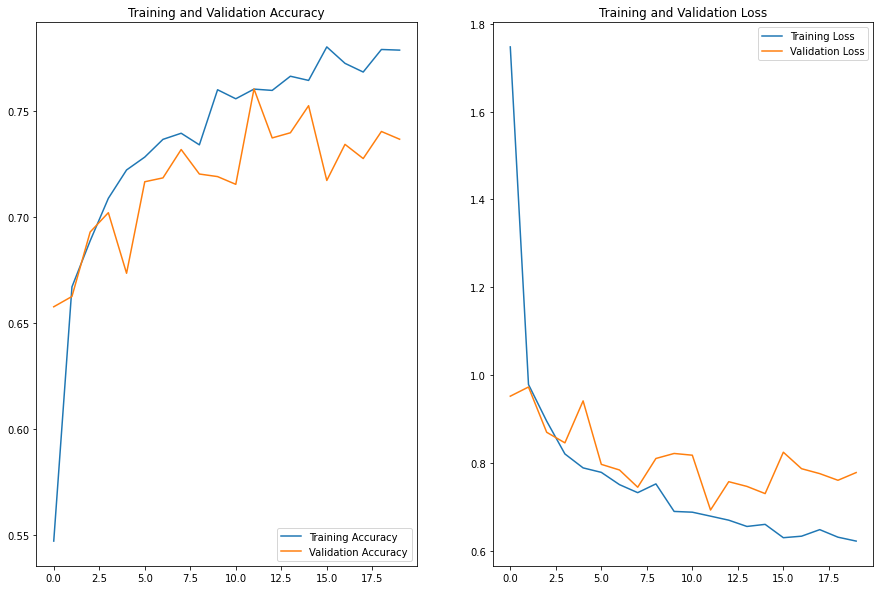

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)

test_generator = test_datagen.flow_from_dataframe(labels_test,directory=test,x_col='image_ID',
                                                    class_mode=None,batch_size=batch_size,
                                                    target_size=(150,150))
odds=pd.DataFrame(model.predict(test_generator))
odds

Found 2056 validated image filenames.


,0,1,2,3,4,5,6
0,0.000012,0.000040,1.275731e-07,0.000082,6.682417e-08,0.999826,4.098481e-05
1,0.001641,0.196425,5.875905e-01,0.117079,2.176895e-06,0.095067,2.195547e-03
2,0.000307,0.029897,4.986162e-06,0.447236,8.888530e-10,0.522554,5.094613e-07
3,0.013781,0.814921,8.499286e-03,0.109551,4.441552e-04,0.007105,4.569786e-02
4,0.000012,0.007145,5.814974e-04,0.987449,5.581335e-05,0.001273,3.483348e-03
...,...,...,...,...,...,...,...
2051,0.017765,0.000019,4.465291e-10,0.000012,6.869082e-11,0.982204,1.867303e-07
2052,0.008943,0.011214,3.877065e-02,0.024086,8.578443e-04,0.904834,1.129476e-02
2053,0.000004,0.999681,8.554628e-08,0.000264,2.809628e-08,0.000003,4.720957e-05
2054,0.004794,0.823140,2.207741e-02,0.098283,3.773485e-05,0.046138,5.530177e-03
